# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

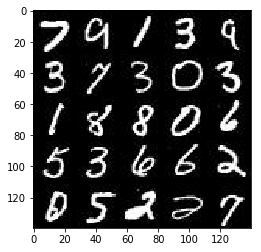

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

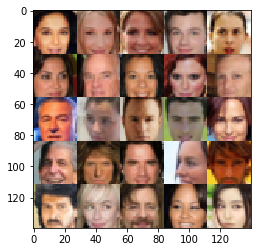

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # I will experiment with different values... if I don't run out of time @floydub
        alpha = 0.2
        kp = 0.9
        #image_size is 28x28xL[dataset] where L={'mnist': 1,'celeba': 3}
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same' )
        x1 = tf.maximum(alpha*x1, x1)
        
        #now 14x14x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same' )
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=kp)
        
        #now 7x7x128
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 1, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=kp)
        
        #now 7x7x256
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # input z noise... start with a dense layer of choice...reshape it... normalize it... leaky relu it
        x1 = tf.layers.dense(z, 7*7*512) #also try starting from 7*7*7*256...
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # now 7x7x512
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        #now 14x14x256
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        #now 28x28x128
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        #now 28x28xL
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, _ = model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # from [-0.5,0.5] to [-1,1]
                batch_images = 2*batch_images
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # I will run and opt generator more than once...
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})  
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                if step%10==0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), "D_Loss: {:.4f}...".format(train_loss_d),"G_Loss: {:.4f}".format(train_loss_g))                
                if step%100==0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)  
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... D_Loss: 6.0058... G_Loss: 0.0081
Epoch 1/2... D_Loss: 4.0567... G_Loss: 0.2039
Epoch 1/2... D_Loss: 4.1354... G_Loss: 0.0402
Epoch 1/2... D_Loss: 2.9411... G_Loss: 0.0987
Epoch 1/2... D_Loss: 2.8063... G_Loss: 0.1534
Epoch 1/2... D_Loss: 2.7162... G_Loss: 0.1873
Epoch 1/2... D_Loss: 2.8347... G_Loss: 0.1575
Epoch 1/2... D_Loss: 2.8279... G_Loss: 0.1551
Epoch 1/2... D_Loss: 2.5948... G_Loss: 0.1702
Epoch 1/2... D_Loss: 2.1699... G_Loss: 0.2354


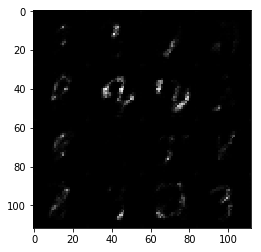

Epoch 1/2... D_Loss: 2.2741... G_Loss: 0.3998
Epoch 1/2... D_Loss: 2.6944... G_Loss: 0.1960
Epoch 1/2... D_Loss: 2.0573... G_Loss: 0.2591
Epoch 1/2... D_Loss: 1.8349... G_Loss: 0.2822
Epoch 1/2... D_Loss: 2.2876... G_Loss: 0.1905
Epoch 1/2... D_Loss: 2.1169... G_Loss: 0.3584
Epoch 1/2... D_Loss: 1.8508... G_Loss: 0.8251
Epoch 1/2... D_Loss: 1.9029... G_Loss: 0.3854
Epoch 1/2... D_Loss: 2.0235... G_Loss: 0.6519
Epoch 1/2... D_Loss: 2.0537... G_Loss: 0.2438


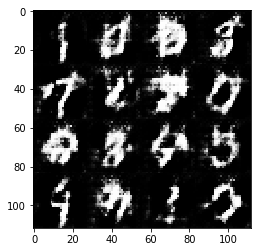

Epoch 1/2... D_Loss: 1.9389... G_Loss: 0.7396
Epoch 1/2... D_Loss: 1.8029... G_Loss: 0.3930
Epoch 1/2... D_Loss: 1.7666... G_Loss: 0.4947
Epoch 1/2... D_Loss: 1.7620... G_Loss: 0.3409
Epoch 1/2... D_Loss: 1.9106... G_Loss: 0.4084
Epoch 1/2... D_Loss: 1.8826... G_Loss: 0.2612
Epoch 1/2... D_Loss: 1.5934... G_Loss: 0.7005
Epoch 1/2... D_Loss: 2.1249... G_Loss: 0.2532
Epoch 1/2... D_Loss: 1.7449... G_Loss: 0.5223
Epoch 1/2... D_Loss: 1.9194... G_Loss: 0.2785


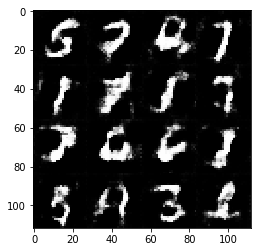

Epoch 1/2... D_Loss: 1.7523... G_Loss: 0.7397
Epoch 1/2... D_Loss: 1.7060... G_Loss: 0.7263
Epoch 1/2... D_Loss: 1.8272... G_Loss: 0.4943
Epoch 1/2... D_Loss: 1.9524... G_Loss: 0.4541
Epoch 1/2... D_Loss: 1.7625... G_Loss: 0.6774
Epoch 1/2... D_Loss: 1.6611... G_Loss: 0.6251
Epoch 1/2... D_Loss: 1.7437... G_Loss: 0.6709
Epoch 1/2... D_Loss: 1.6602... G_Loss: 0.3959
Epoch 1/2... D_Loss: 1.8938... G_Loss: 0.3257
Epoch 1/2... D_Loss: 2.0734... G_Loss: 0.2288


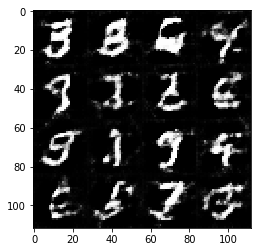

Epoch 1/2... D_Loss: 1.7070... G_Loss: 0.5636
Epoch 1/2... D_Loss: 1.9127... G_Loss: 0.2285
Epoch 1/2... D_Loss: 1.7072... G_Loss: 0.7323
Epoch 1/2... D_Loss: 1.7494... G_Loss: 0.5372
Epoch 1/2... D_Loss: 1.9091... G_Loss: 0.2711
Epoch 1/2... D_Loss: 1.7732... G_Loss: 0.9680
Epoch 1/2... D_Loss: 1.6437... G_Loss: 0.4686
Epoch 1/2... D_Loss: 1.6154... G_Loss: 0.7535
Epoch 1/2... D_Loss: 1.7339... G_Loss: 0.4635
Epoch 1/2... D_Loss: 1.9854... G_Loss: 0.3186


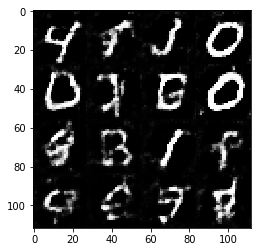

Epoch 1/2... D_Loss: 1.7725... G_Loss: 1.2255
Epoch 1/2... D_Loss: 1.6469... G_Loss: 0.7442
Epoch 1/2... D_Loss: 1.6195... G_Loss: 0.6152
Epoch 1/2... D_Loss: 1.7349... G_Loss: 0.4399
Epoch 1/2... D_Loss: 1.6747... G_Loss: 0.4686
Epoch 1/2... D_Loss: 1.6468... G_Loss: 0.8385
Epoch 1/2... D_Loss: 1.7758... G_Loss: 0.3144
Epoch 1/2... D_Loss: 1.5680... G_Loss: 0.7984
Epoch 1/2... D_Loss: 1.6746... G_Loss: 0.5215
Epoch 1/2... D_Loss: 1.6497... G_Loss: 0.4537


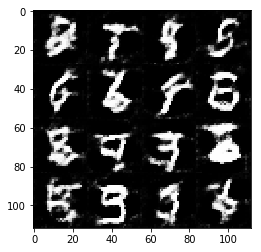

Epoch 1/2... D_Loss: 1.7661... G_Loss: 0.4421
Epoch 1/2... D_Loss: 1.7933... G_Loss: 0.4150
Epoch 1/2... D_Loss: 1.6511... G_Loss: 0.5171
Epoch 1/2... D_Loss: 1.7229... G_Loss: 0.7678
Epoch 1/2... D_Loss: 1.6020... G_Loss: 0.4692
Epoch 1/2... D_Loss: 1.8750... G_Loss: 0.2836
Epoch 1/2... D_Loss: 1.7062... G_Loss: 0.3805
Epoch 1/2... D_Loss: 1.6322... G_Loss: 0.7836
Epoch 1/2... D_Loss: 1.6482... G_Loss: 0.4013
Epoch 1/2... D_Loss: 1.7971... G_Loss: 0.9754


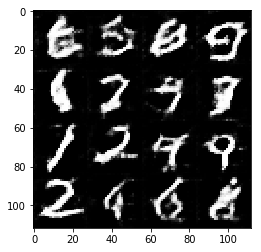

Epoch 1/2... D_Loss: 1.7415... G_Loss: 0.3329
Epoch 1/2... D_Loss: 1.5732... G_Loss: 0.5905
Epoch 1/2... D_Loss: 1.7772... G_Loss: 0.9914
Epoch 1/2... D_Loss: 1.7789... G_Loss: 0.3024
Epoch 1/2... D_Loss: 1.6547... G_Loss: 0.4261
Epoch 1/2... D_Loss: 1.9239... G_Loss: 0.7806
Epoch 1/2... D_Loss: 1.8155... G_Loss: 0.8213
Epoch 1/2... D_Loss: 1.7309... G_Loss: 0.5993
Epoch 1/2... D_Loss: 1.6866... G_Loss: 0.5142
Epoch 1/2... D_Loss: 1.6719... G_Loss: 0.6133


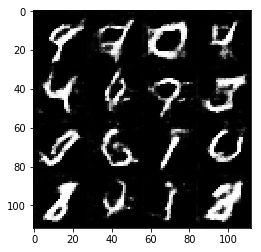

Epoch 1/2... D_Loss: 1.9046... G_Loss: 1.0465
Epoch 1/2... D_Loss: 1.8033... G_Loss: 0.8231
Epoch 1/2... D_Loss: 1.6313... G_Loss: 0.4688
Epoch 1/2... D_Loss: 1.6404... G_Loss: 0.5799
Epoch 1/2... D_Loss: 1.7450... G_Loss: 0.4896
Epoch 1/2... D_Loss: 1.8833... G_Loss: 0.2658
Epoch 1/2... D_Loss: 1.7273... G_Loss: 0.3627
Epoch 1/2... D_Loss: 1.7240... G_Loss: 1.0237
Epoch 1/2... D_Loss: 1.6528... G_Loss: 0.6748
Epoch 1/2... D_Loss: 1.7654... G_Loss: 0.3192


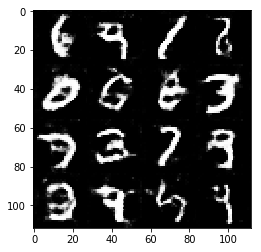

Epoch 1/2... D_Loss: 1.6310... G_Loss: 0.4071
Epoch 1/2... D_Loss: 1.6335... G_Loss: 0.6772
Epoch 1/2... D_Loss: 2.0224... G_Loss: 1.0369
Epoch 1/2... D_Loss: 1.5978... G_Loss: 0.5055
Epoch 1/2... D_Loss: 1.7309... G_Loss: 0.3236
Epoch 1/2... D_Loss: 1.6962... G_Loss: 0.3995
Epoch 1/2... D_Loss: 1.8835... G_Loss: 0.5798
Epoch 1/2... D_Loss: 1.7405... G_Loss: 0.7826
Epoch 1/2... D_Loss: 1.7252... G_Loss: 0.3466
Epoch 1/2... D_Loss: 1.6878... G_Loss: 0.6359


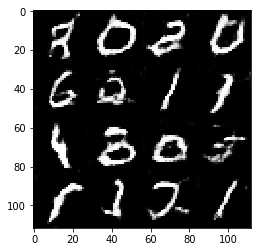

Epoch 1/2... D_Loss: 1.6845... G_Loss: 0.6527
Epoch 1/2... D_Loss: 1.8589... G_Loss: 0.2839
Epoch 1/2... D_Loss: 1.5716... G_Loss: 0.5341
Epoch 1/2... D_Loss: 2.0795... G_Loss: 1.1959
Epoch 1/2... D_Loss: 1.6551... G_Loss: 0.3905
Epoch 1/2... D_Loss: 1.5593... G_Loss: 0.7536
Epoch 1/2... D_Loss: 1.7487... G_Loss: 0.3031
Epoch 1/2... D_Loss: 1.8957... G_Loss: 0.2705
Epoch 1/2... D_Loss: 1.6382... G_Loss: 0.6140
Epoch 1/2... D_Loss: 2.1625... G_Loss: 0.1921


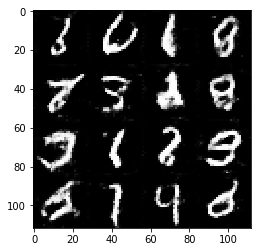

Epoch 1/2... D_Loss: 1.8177... G_Loss: 0.2774
Epoch 1/2... D_Loss: 1.7031... G_Loss: 0.7920
Epoch 1/2... D_Loss: 2.0381... G_Loss: 0.2038
Epoch 1/2... D_Loss: 1.6211... G_Loss: 0.7214
Epoch 1/2... D_Loss: 1.5540... G_Loss: 0.3798
Epoch 1/2... D_Loss: 1.6136... G_Loss: 0.5487
Epoch 1/2... D_Loss: 1.6065... G_Loss: 0.6582
Epoch 1/2... D_Loss: 1.9849... G_Loss: 0.2108
Epoch 1/2... D_Loss: 1.6426... G_Loss: 0.4928
Epoch 1/2... D_Loss: 1.8039... G_Loss: 0.4510


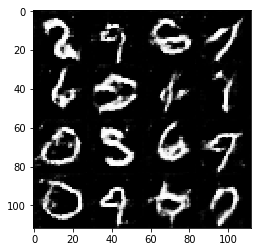

Epoch 1/2... D_Loss: 1.6491... G_Loss: 0.5900
Epoch 1/2... D_Loss: 1.5601... G_Loss: 0.5324
Epoch 1/2... D_Loss: 1.6093... G_Loss: 0.3866
Epoch 1/2... D_Loss: 1.5491... G_Loss: 0.7528
Epoch 1/2... D_Loss: 1.9334... G_Loss: 0.1986
Epoch 1/2... D_Loss: 1.8156... G_Loss: 0.2669
Epoch 1/2... D_Loss: 1.7626... G_Loss: 0.2979
Epoch 1/2... D_Loss: 1.5312... G_Loss: 0.7786
Epoch 1/2... D_Loss: 2.0646... G_Loss: 0.1810
Epoch 1/2... D_Loss: 1.5408... G_Loss: 0.4824


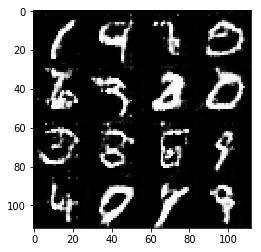

Epoch 1/2... D_Loss: 1.9858... G_Loss: 0.2529
Epoch 1/2... D_Loss: 1.6010... G_Loss: 0.6344
Epoch 1/2... D_Loss: 1.9675... G_Loss: 0.1825
Epoch 1/2... D_Loss: 1.7096... G_Loss: 0.7268
Epoch 1/2... D_Loss: 1.7906... G_Loss: 0.2422
Epoch 1/2... D_Loss: 1.7627... G_Loss: 0.3041
Epoch 1/2... D_Loss: 1.6347... G_Loss: 0.4001
Epoch 1/2... D_Loss: 1.5646... G_Loss: 0.3238
Epoch 1/2... D_Loss: 1.7501... G_Loss: 0.6100
Epoch 1/2... D_Loss: 1.5899... G_Loss: 0.4798


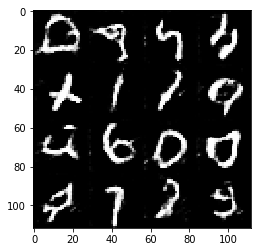

Epoch 1/2... D_Loss: 1.7452... G_Loss: 0.2686
Epoch 1/2... D_Loss: 1.9817... G_Loss: 0.8256
Epoch 1/2... D_Loss: 1.5504... G_Loss: 0.6707
Epoch 1/2... D_Loss: 1.7433... G_Loss: 0.4182
Epoch 1/2... D_Loss: 1.8732... G_Loss: 0.2897
Epoch 1/2... D_Loss: 1.8799... G_Loss: 0.2068
Epoch 1/2... D_Loss: 1.4818... G_Loss: 0.8844
Epoch 1/2... D_Loss: 1.7180... G_Loss: 0.8026
Epoch 1/2... D_Loss: 1.9699... G_Loss: 0.2351
Epoch 1/2... D_Loss: 2.0464... G_Loss: 0.1847


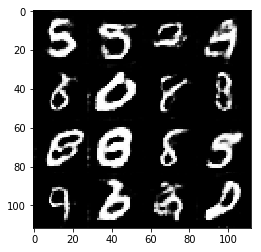

Epoch 1/2... D_Loss: 1.6405... G_Loss: 0.5765
Epoch 1/2... D_Loss: 1.8778... G_Loss: 0.2576
Epoch 1/2... D_Loss: 1.7604... G_Loss: 0.3442
Epoch 1/2... D_Loss: 1.6653... G_Loss: 0.3388
Epoch 1/2... D_Loss: 1.7285... G_Loss: 0.2862
Epoch 1/2... D_Loss: 1.8700... G_Loss: 0.1984
Epoch 1/2... D_Loss: 1.5701... G_Loss: 0.4614
Epoch 1/2... D_Loss: 1.6991... G_Loss: 0.3869
Epoch 1/2... D_Loss: 1.9817... G_Loss: 0.2337
Epoch 1/2... D_Loss: 1.7660... G_Loss: 0.3997


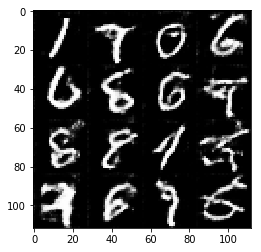

Epoch 1/2... D_Loss: 1.7135... G_Loss: 0.3203
Epoch 1/2... D_Loss: 1.7339... G_Loss: 0.3196
Epoch 1/2... D_Loss: 1.6765... G_Loss: 0.2811
Epoch 1/2... D_Loss: 1.8113... G_Loss: 1.0047
Epoch 1/2... D_Loss: 1.6330... G_Loss: 0.7992
Epoch 1/2... D_Loss: 1.4789... G_Loss: 0.5798
Epoch 1/2... D_Loss: 1.8245... G_Loss: 0.3939
Epoch 1/2... D_Loss: 1.7331... G_Loss: 0.3772
Epoch 1/2... D_Loss: 1.7952... G_Loss: 0.3427
Epoch 1/2... D_Loss: 1.6984... G_Loss: 0.4978


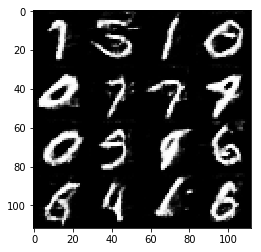

Epoch 1/2... D_Loss: 1.4107... G_Loss: 0.6070
Epoch 1/2... D_Loss: 1.8861... G_Loss: 0.2238
Epoch 1/2... D_Loss: 1.4918... G_Loss: 0.9509
Epoch 1/2... D_Loss: 1.8915... G_Loss: 0.2173
Epoch 1/2... D_Loss: 1.7540... G_Loss: 0.3671
Epoch 1/2... D_Loss: 1.7088... G_Loss: 0.4921
Epoch 1/2... D_Loss: 1.4685... G_Loss: 0.6179
Epoch 1/2... D_Loss: 1.8724... G_Loss: 0.2992
Epoch 1/2... D_Loss: 2.0560... G_Loss: 0.1840
Epoch 1/2... D_Loss: 1.5148... G_Loss: 0.4195


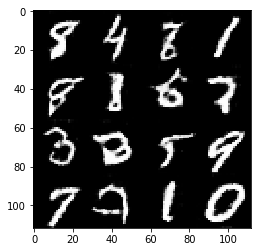

Epoch 1/2... D_Loss: 2.8582... G_Loss: 0.0887
Epoch 1/2... D_Loss: 1.7770... G_Loss: 0.2641
Epoch 1/2... D_Loss: 1.8497... G_Loss: 0.4642
Epoch 1/2... D_Loss: 1.6972... G_Loss: 0.3513
Epoch 1/2... D_Loss: 1.4638... G_Loss: 0.7849
Epoch 1/2... D_Loss: 1.4432... G_Loss: 0.6345
Epoch 1/2... D_Loss: 3.5301... G_Loss: 0.0444
Epoch 2/2... D_Loss: 1.4808... G_Loss: 0.4579
Epoch 2/2... D_Loss: 1.6641... G_Loss: 0.4993
Epoch 2/2... D_Loss: 1.9553... G_Loss: 0.2092


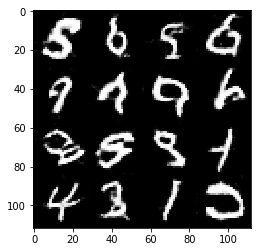

Epoch 2/2... D_Loss: 1.7741... G_Loss: 0.4803
Epoch 2/2... D_Loss: 1.6585... G_Loss: 0.3193
Epoch 2/2... D_Loss: 1.3357... G_Loss: 1.4281
Epoch 2/2... D_Loss: 1.3967... G_Loss: 0.8230
Epoch 2/2... D_Loss: 1.5429... G_Loss: 0.8164
Epoch 2/2... D_Loss: 1.3547... G_Loss: 0.5404
Epoch 2/2... D_Loss: 1.6131... G_Loss: 0.4949
Epoch 2/2... D_Loss: 2.0874... G_Loss: 0.2096
Epoch 2/2... D_Loss: 2.0679... G_Loss: 0.2454
Epoch 2/2... D_Loss: 1.8972... G_Loss: 0.2659


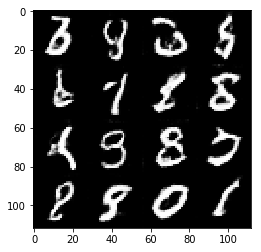

Epoch 2/2... D_Loss: 1.9330... G_Loss: 0.2446
Epoch 2/2... D_Loss: 1.4250... G_Loss: 0.4441
Epoch 2/2... D_Loss: 2.0259... G_Loss: 0.1689
Epoch 2/2... D_Loss: 1.6138... G_Loss: 0.4414
Epoch 2/2... D_Loss: 2.0457... G_Loss: 0.2768
Epoch 2/2... D_Loss: 1.6177... G_Loss: 0.3284
Epoch 2/2... D_Loss: 1.6608... G_Loss: 0.4318
Epoch 2/2... D_Loss: 1.4158... G_Loss: 0.6600
Epoch 2/2... D_Loss: 1.5310... G_Loss: 0.3760
Epoch 2/2... D_Loss: 1.7972... G_Loss: 0.3045


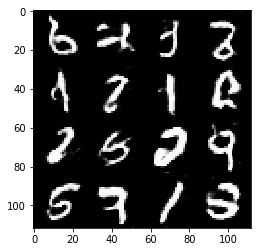

Epoch 2/2... D_Loss: 1.6317... G_Loss: 0.3841
Epoch 2/2... D_Loss: 1.5961... G_Loss: 0.7542
Epoch 2/2... D_Loss: 1.5172... G_Loss: 0.4931
Epoch 2/2... D_Loss: 1.4893... G_Loss: 0.4324
Epoch 2/2... D_Loss: 1.5244... G_Loss: 0.6819
Epoch 2/2... D_Loss: 2.1789... G_Loss: 0.1680
Epoch 2/2... D_Loss: 1.9517... G_Loss: 0.1958
Epoch 2/2... D_Loss: 1.7548... G_Loss: 0.2456
Epoch 2/2... D_Loss: 1.5931... G_Loss: 0.7699
Epoch 2/2... D_Loss: 1.5490... G_Loss: 0.5910


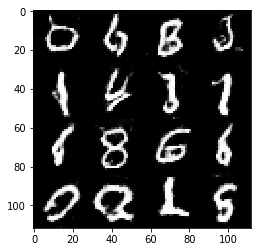

Epoch 2/2... D_Loss: 1.8404... G_Loss: 0.3237
Epoch 2/2... D_Loss: 1.4998... G_Loss: 0.6035
Epoch 2/2... D_Loss: 1.8431... G_Loss: 0.2945
Epoch 2/2... D_Loss: 1.9981... G_Loss: 0.2516
Epoch 2/2... D_Loss: 1.8347... G_Loss: 0.3324
Epoch 2/2... D_Loss: 1.9958... G_Loss: 0.1960
Epoch 2/2... D_Loss: 1.6183... G_Loss: 0.8179
Epoch 2/2... D_Loss: 1.6007... G_Loss: 0.6141
Epoch 2/2... D_Loss: 1.8769... G_Loss: 0.2845
Epoch 2/2... D_Loss: 2.4139... G_Loss: 0.1404


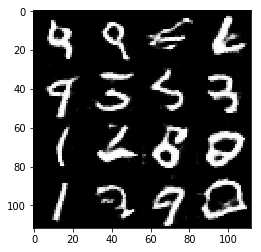

Epoch 2/2... D_Loss: 2.1868... G_Loss: 0.1451
Epoch 2/2... D_Loss: 2.1715... G_Loss: 0.1840
Epoch 2/2... D_Loss: 1.5751... G_Loss: 0.5944
Epoch 2/2... D_Loss: 1.7090... G_Loss: 0.3136
Epoch 2/2... D_Loss: 2.0554... G_Loss: 0.1860
Epoch 2/2... D_Loss: 1.5585... G_Loss: 0.9364
Epoch 2/2... D_Loss: 1.7644... G_Loss: 0.6945
Epoch 2/2... D_Loss: 1.7477... G_Loss: 0.4130
Epoch 2/2... D_Loss: 1.3217... G_Loss: 1.0059
Epoch 2/2... D_Loss: 1.9284... G_Loss: 0.2848


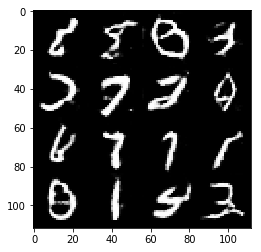

Epoch 2/2... D_Loss: 1.7872... G_Loss: 0.2551
Epoch 2/2... D_Loss: 1.3036... G_Loss: 0.8279
Epoch 2/2... D_Loss: 2.2714... G_Loss: 0.1510
Epoch 2/2... D_Loss: 2.2539... G_Loss: 0.1713
Epoch 2/2... D_Loss: 2.0935... G_Loss: 0.1804
Epoch 2/2... D_Loss: 1.7899... G_Loss: 0.2621
Epoch 2/2... D_Loss: 1.2447... G_Loss: 0.6784
Epoch 2/2... D_Loss: 1.4698... G_Loss: 0.7655
Epoch 2/2... D_Loss: 1.7181... G_Loss: 0.3246
Epoch 2/2... D_Loss: 1.8780... G_Loss: 0.2210


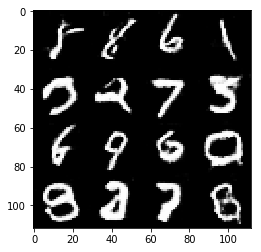

Epoch 2/2... D_Loss: 1.6923... G_Loss: 0.5728
Epoch 2/2... D_Loss: 1.3319... G_Loss: 0.6269
Epoch 2/2... D_Loss: 2.0168... G_Loss: 0.2134
Epoch 2/2... D_Loss: 1.3469... G_Loss: 0.6391
Epoch 2/2... D_Loss: 1.5231... G_Loss: 0.7674
Epoch 2/2... D_Loss: 1.7770... G_Loss: 0.3005
Epoch 2/2... D_Loss: 1.9348... G_Loss: 0.3252
Epoch 2/2... D_Loss: 2.6683... G_Loss: 0.1207
Epoch 2/2... D_Loss: 1.6037... G_Loss: 1.5602
Epoch 2/2... D_Loss: 1.1708... G_Loss: 0.6536


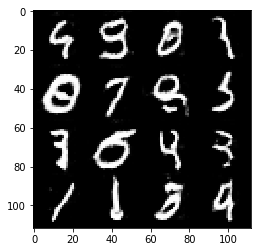

Epoch 2/2... D_Loss: 1.6732... G_Loss: 0.4546
Epoch 2/2... D_Loss: 1.9716... G_Loss: 0.2860
Epoch 2/2... D_Loss: 1.2812... G_Loss: 0.9545
Epoch 2/2... D_Loss: 1.7786... G_Loss: 0.3346
Epoch 2/2... D_Loss: 1.6009... G_Loss: 0.3591
Epoch 2/2... D_Loss: 2.2284... G_Loss: 0.1812
Epoch 2/2... D_Loss: 2.3234... G_Loss: 0.1764
Epoch 2/2... D_Loss: 1.3493... G_Loss: 0.7419
Epoch 2/2... D_Loss: 1.5835... G_Loss: 0.5698
Epoch 2/2... D_Loss: 1.7133... G_Loss: 0.2903


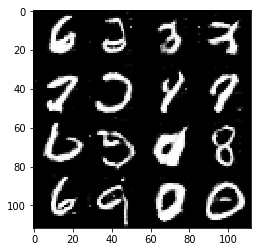

Epoch 2/2... D_Loss: 1.6960... G_Loss: 0.3355
Epoch 2/2... D_Loss: 1.6760... G_Loss: 0.4832
Epoch 2/2... D_Loss: 1.2929... G_Loss: 0.8076
Epoch 2/2... D_Loss: 1.7445... G_Loss: 0.3270
Epoch 2/2... D_Loss: 2.1746... G_Loss: 0.2016
Epoch 2/2... D_Loss: 1.5631... G_Loss: 0.7360
Epoch 2/2... D_Loss: 2.5186... G_Loss: 0.1607
Epoch 2/2... D_Loss: 1.4026... G_Loss: 0.5694
Epoch 2/2... D_Loss: 2.0045... G_Loss: 0.3290
Epoch 2/2... D_Loss: 1.6643... G_Loss: 0.3921


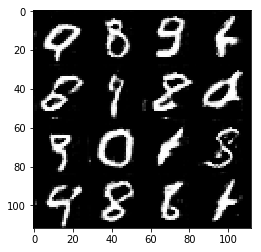

Epoch 2/2... D_Loss: 1.3739... G_Loss: 0.4818
Epoch 2/2... D_Loss: 1.8054... G_Loss: 0.3114
Epoch 2/2... D_Loss: 1.4577... G_Loss: 0.4239
Epoch 2/2... D_Loss: 1.5893... G_Loss: 0.4459
Epoch 2/2... D_Loss: 1.8970... G_Loss: 0.2267
Epoch 2/2... D_Loss: 1.5399... G_Loss: 0.8998
Epoch 2/2... D_Loss: 2.0502... G_Loss: 0.2297
Epoch 2/2... D_Loss: 1.8948... G_Loss: 0.2610
Epoch 2/2... D_Loss: 1.4567... G_Loss: 0.5360
Epoch 2/2... D_Loss: 1.7536... G_Loss: 0.3689


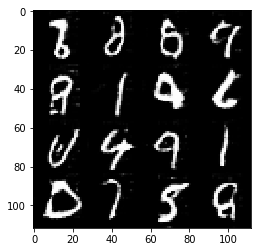

Epoch 2/2... D_Loss: 2.5912... G_Loss: 0.1345
Epoch 2/2... D_Loss: 1.5048... G_Loss: 0.5415
Epoch 2/2... D_Loss: 1.3537... G_Loss: 0.4901
Epoch 2/2... D_Loss: 1.9656... G_Loss: 0.2250
Epoch 2/2... D_Loss: 1.5488... G_Loss: 0.6369
Epoch 2/2... D_Loss: 1.6818... G_Loss: 0.4159
Epoch 2/2... D_Loss: 1.3653... G_Loss: 0.5916
Epoch 2/2... D_Loss: 1.5893... G_Loss: 0.4194
Epoch 2/2... D_Loss: 1.5783... G_Loss: 0.3950
Epoch 2/2... D_Loss: 1.4136... G_Loss: 0.4720


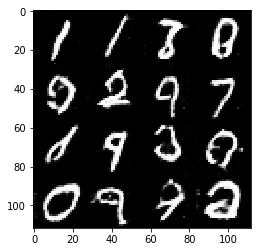

Epoch 2/2... D_Loss: 1.6201... G_Loss: 0.3396
Epoch 2/2... D_Loss: 1.8943... G_Loss: 0.2692
Epoch 2/2... D_Loss: 1.3379... G_Loss: 0.4813
Epoch 2/2... D_Loss: 1.5561... G_Loss: 0.5415
Epoch 2/2... D_Loss: 1.5490... G_Loss: 1.0820
Epoch 2/2... D_Loss: 1.4957... G_Loss: 0.7635
Epoch 2/2... D_Loss: 2.1445... G_Loss: 0.1823
Epoch 2/2... D_Loss: 1.7020... G_Loss: 0.2966
Epoch 2/2... D_Loss: 1.4970... G_Loss: 0.3927
Epoch 2/2... D_Loss: 2.1333... G_Loss: 0.2385


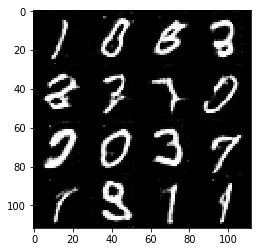

Epoch 2/2... D_Loss: 2.1073... G_Loss: 0.1726
Epoch 2/2... D_Loss: 1.7393... G_Loss: 0.3010
Epoch 2/2... D_Loss: 2.7307... G_Loss: 0.1147
Epoch 2/2... D_Loss: 1.7433... G_Loss: 1.0247
Epoch 2/2... D_Loss: 2.0078... G_Loss: 0.2306
Epoch 2/2... D_Loss: 1.6298... G_Loss: 0.4091
Epoch 2/2... D_Loss: 2.8237... G_Loss: 0.1424
Epoch 2/2... D_Loss: 1.6441... G_Loss: 0.4288
Epoch 2/2... D_Loss: 1.7507... G_Loss: 0.7001
Epoch 2/2... D_Loss: 1.3344... G_Loss: 0.5523


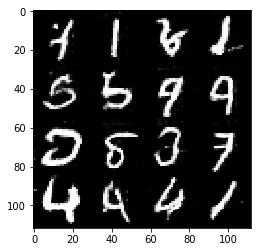

Epoch 2/2... D_Loss: 1.9429... G_Loss: 0.2322
Epoch 2/2... D_Loss: 2.2545... G_Loss: 0.1735
Epoch 2/2... D_Loss: 1.2834... G_Loss: 0.6450
Epoch 2/2... D_Loss: 1.9788... G_Loss: 0.3684
Epoch 2/2... D_Loss: 1.5600... G_Loss: 0.5287
Epoch 2/2... D_Loss: 1.7103... G_Loss: 0.4055
Epoch 2/2... D_Loss: 1.8144... G_Loss: 0.4156
Epoch 2/2... D_Loss: 1.4034... G_Loss: 0.6380
Epoch 2/2... D_Loss: 1.7343... G_Loss: 0.2773
Epoch 2/2... D_Loss: 1.5641... G_Loss: 0.4173


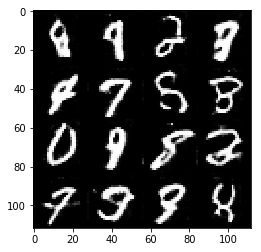

Epoch 2/2... D_Loss: 2.4066... G_Loss: 0.1479
Epoch 2/2... D_Loss: 1.8371... G_Loss: 0.3151
Epoch 2/2... D_Loss: 2.0752... G_Loss: 0.2062
Epoch 2/2... D_Loss: 1.5371... G_Loss: 0.3154
Epoch 2/2... D_Loss: 1.5813... G_Loss: 0.3546
Epoch 2/2... D_Loss: 1.6054... G_Loss: 0.3717
Epoch 2/2... D_Loss: 1.6505... G_Loss: 0.8236
Epoch 2/2... D_Loss: 2.1483... G_Loss: 0.3170
Epoch 2/2... D_Loss: 1.7785... G_Loss: 0.3133
Epoch 2/2... D_Loss: 2.0668... G_Loss: 0.2813


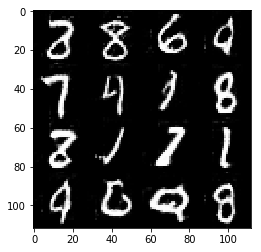

Epoch 2/2... D_Loss: 1.5240... G_Loss: 0.4422
Epoch 2/2... D_Loss: 1.7417... G_Loss: 0.2820
Epoch 2/2... D_Loss: 1.5925... G_Loss: 0.5863
Epoch 2/2... D_Loss: 1.8492... G_Loss: 0.2894
Epoch 2/2... D_Loss: 1.9515... G_Loss: 0.2181
Epoch 2/2... D_Loss: 1.1695... G_Loss: 0.5740
Epoch 2/2... D_Loss: 2.6417... G_Loss: 0.1233
Epoch 2/2... D_Loss: 1.8102... G_Loss: 0.3456
Epoch 2/2... D_Loss: 1.7314... G_Loss: 0.2879
Epoch 2/2... D_Loss: 1.5367... G_Loss: 0.7190


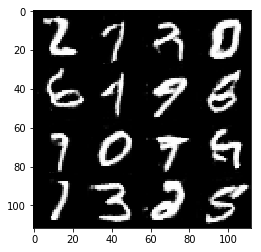

Epoch 2/2... D_Loss: 1.6078... G_Loss: 0.3376
Epoch 2/2... D_Loss: 1.5357... G_Loss: 0.5908
Epoch 2/2... D_Loss: 2.3195... G_Loss: 0.1325
Epoch 2/2... D_Loss: 1.6650... G_Loss: 0.2774
Epoch 2/2... D_Loss: 1.5969... G_Loss: 0.7917
Epoch 2/2... D_Loss: 2.1836... G_Loss: 0.2247
Epoch 2/2... D_Loss: 1.9809... G_Loss: 0.3059
Epoch 2/2... D_Loss: 1.1774... G_Loss: 1.5468
Epoch 2/2... D_Loss: 1.4583... G_Loss: 1.1409
Epoch 2/2... D_Loss: 1.1042... G_Loss: 0.8508


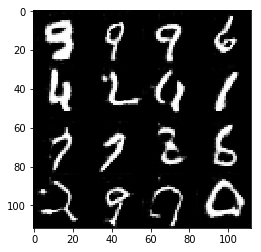

Epoch 2/2... D_Loss: 1.8214... G_Loss: 0.3401
Epoch 2/2... D_Loss: 1.1752... G_Loss: 0.9207
Epoch 2/2... D_Loss: 2.4633... G_Loss: 0.1411
Epoch 2/2... D_Loss: 1.9051... G_Loss: 0.3159
Epoch 2/2... D_Loss: 2.5727... G_Loss: 0.1322
Epoch 2/2... D_Loss: 2.1651... G_Loss: 0.2975
Epoch 2/2... D_Loss: 1.8336... G_Loss: 0.2345
Epoch 2/2... D_Loss: 1.6278... G_Loss: 0.4307
Epoch 2/2... D_Loss: 1.5211... G_Loss: 0.4606
Epoch 2/2... D_Loss: 2.3063... G_Loss: 0.1352


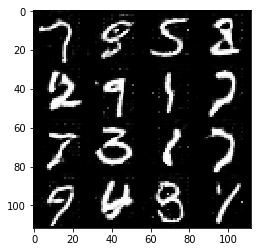

Epoch 2/2... D_Loss: 1.8329... G_Loss: 0.2687
Epoch 2/2... D_Loss: 1.5781... G_Loss: 0.4333
Epoch 2/2... D_Loss: 1.6637... G_Loss: 1.9279
Epoch 2/2... D_Loss: 1.8280... G_Loss: 0.3730
Epoch 2/2... D_Loss: 1.8130... G_Loss: 0.3208


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... D_Loss: 2.2359... G_Loss: 7.2405
Epoch 1/1... D_Loss: 2.8349... G_Loss: 0.6329
Epoch 1/1... D_Loss: 2.7678... G_Loss: 0.3195
Epoch 1/1... D_Loss: 2.2769... G_Loss: 0.2861
Epoch 1/1... D_Loss: 1.5491... G_Loss: 0.7858
Epoch 1/1... D_Loss: 1.1765... G_Loss: 0.6730
Epoch 1/1... D_Loss: 2.2661... G_Loss: 0.1861
Epoch 1/1... D_Loss: 1.7050... G_Loss: 0.7346
Epoch 1/1... D_Loss: 2.4525... G_Loss: 0.4649
Epoch 1/1... D_Loss: 2.5014... G_Loss: 0.3001


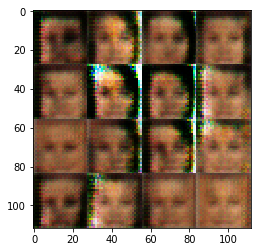

Epoch 1/1... D_Loss: 1.8729... G_Loss: 0.4716
Epoch 1/1... D_Loss: 2.1765... G_Loss: 0.4110
Epoch 1/1... D_Loss: 1.6323... G_Loss: 0.5532
Epoch 1/1... D_Loss: 2.0893... G_Loss: 0.5930
Epoch 1/1... D_Loss: 2.1254... G_Loss: 0.5285
Epoch 1/1... D_Loss: 1.7906... G_Loss: 0.3750
Epoch 1/1... D_Loss: 1.9668... G_Loss: 0.4843
Epoch 1/1... D_Loss: 1.9563... G_Loss: 0.7914
Epoch 1/1... D_Loss: 1.6026... G_Loss: 0.6782
Epoch 1/1... D_Loss: 1.7269... G_Loss: 0.5968


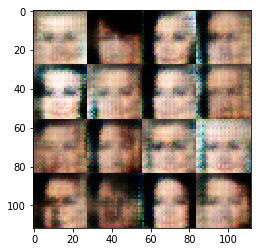

Epoch 1/1... D_Loss: 1.8598... G_Loss: 0.4512
Epoch 1/1... D_Loss: 1.7601... G_Loss: 0.6804
Epoch 1/1... D_Loss: 1.5514... G_Loss: 0.8472
Epoch 1/1... D_Loss: 1.6072... G_Loss: 0.6564
Epoch 1/1... D_Loss: 1.5688... G_Loss: 0.7291
Epoch 1/1... D_Loss: 1.6839... G_Loss: 0.5915
Epoch 1/1... D_Loss: 1.6519... G_Loss: 0.5761
Epoch 1/1... D_Loss: 1.8390... G_Loss: 0.5403
Epoch 1/1... D_Loss: 1.4330... G_Loss: 0.6429
Epoch 1/1... D_Loss: 1.7401... G_Loss: 0.5727


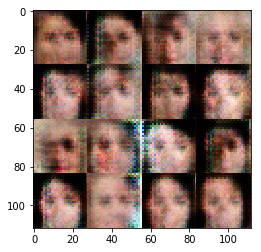

Epoch 1/1... D_Loss: 1.6424... G_Loss: 0.6771
Epoch 1/1... D_Loss: 1.5790... G_Loss: 0.6271
Epoch 1/1... D_Loss: 1.6528... G_Loss: 0.4801
Epoch 1/1... D_Loss: 1.6631... G_Loss: 0.8238
Epoch 1/1... D_Loss: 1.5619... G_Loss: 0.5992
Epoch 1/1... D_Loss: 1.8475... G_Loss: 0.6305
Epoch 1/1... D_Loss: 1.5358... G_Loss: 0.6872
Epoch 1/1... D_Loss: 1.5796... G_Loss: 0.5585
Epoch 1/1... D_Loss: 1.5126... G_Loss: 0.6789
Epoch 1/1... D_Loss: 1.5897... G_Loss: 0.5429


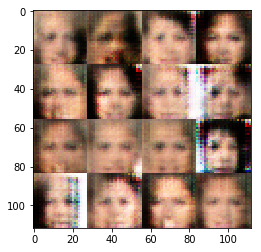

Epoch 1/1... D_Loss: 1.7420... G_Loss: 0.5962
Epoch 1/1... D_Loss: 1.8673... G_Loss: 0.5325
Epoch 1/1... D_Loss: 1.8268... G_Loss: 0.6468
Epoch 1/1... D_Loss: 1.7939... G_Loss: 0.4463
Epoch 1/1... D_Loss: 1.8801... G_Loss: 0.6484
Epoch 1/1... D_Loss: 1.5873... G_Loss: 0.5328
Epoch 1/1... D_Loss: 1.8667... G_Loss: 0.6007
Epoch 1/1... D_Loss: 1.6951... G_Loss: 0.7039
Epoch 1/1... D_Loss: 1.8311... G_Loss: 0.4185
Epoch 1/1... D_Loss: 1.9034... G_Loss: 0.5359


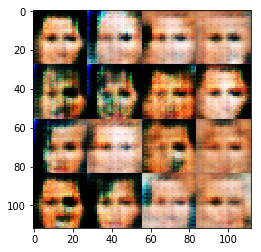

Epoch 1/1... D_Loss: 1.5802... G_Loss: 0.8452
Epoch 1/1... D_Loss: 1.6956... G_Loss: 0.6674
Epoch 1/1... D_Loss: 1.5199... G_Loss: 0.7070
Epoch 1/1... D_Loss: 1.5758... G_Loss: 0.8165
Epoch 1/1... D_Loss: 1.4690... G_Loss: 0.6710
Epoch 1/1... D_Loss: 1.7341... G_Loss: 0.5175
Epoch 1/1... D_Loss: 1.7197... G_Loss: 0.6856
Epoch 1/1... D_Loss: 1.6310... G_Loss: 0.8360
Epoch 1/1... D_Loss: 1.6100... G_Loss: 0.7203
Epoch 1/1... D_Loss: 1.5265... G_Loss: 0.6550


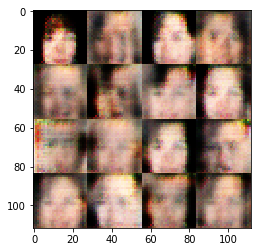

Epoch 1/1... D_Loss: 1.8453... G_Loss: 0.4659
Epoch 1/1... D_Loss: 1.5643... G_Loss: 0.5905
Epoch 1/1... D_Loss: 1.6034... G_Loss: 0.8103
Epoch 1/1... D_Loss: 1.6006... G_Loss: 0.6078
Epoch 1/1... D_Loss: 1.5263... G_Loss: 0.6665
Epoch 1/1... D_Loss: 1.5034... G_Loss: 0.6328
Epoch 1/1... D_Loss: 1.5914... G_Loss: 0.5498
Epoch 1/1... D_Loss: 1.5233... G_Loss: 0.6917
Epoch 1/1... D_Loss: 1.4440... G_Loss: 0.6601
Epoch 1/1... D_Loss: 1.5223... G_Loss: 0.7571


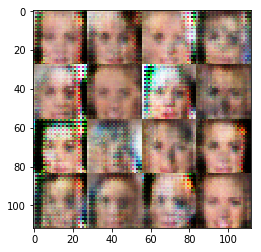

Epoch 1/1... D_Loss: 1.5839... G_Loss: 0.8504
Epoch 1/1... D_Loss: 1.4750... G_Loss: 0.6863
Epoch 1/1... D_Loss: 1.5540... G_Loss: 0.7308
Epoch 1/1... D_Loss: 1.4731... G_Loss: 0.6112
Epoch 1/1... D_Loss: 1.6013... G_Loss: 0.6078
Epoch 1/1... D_Loss: 1.5496... G_Loss: 0.5800
Epoch 1/1... D_Loss: 1.7048... G_Loss: 0.5500
Epoch 1/1... D_Loss: 1.4566... G_Loss: 0.7484
Epoch 1/1... D_Loss: 1.6282... G_Loss: 0.8168
Epoch 1/1... D_Loss: 1.4952... G_Loss: 0.6382


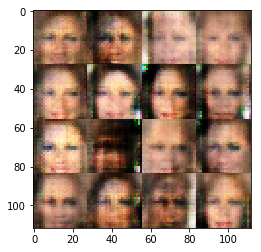

Epoch 1/1... D_Loss: 1.5181... G_Loss: 0.7074
Epoch 1/1... D_Loss: 1.6230... G_Loss: 0.4620
Epoch 1/1... D_Loss: 1.4129... G_Loss: 0.6030
Epoch 1/1... D_Loss: 1.5886... G_Loss: 0.5813
Epoch 1/1... D_Loss: 1.4480... G_Loss: 0.6422
Epoch 1/1... D_Loss: 1.5331... G_Loss: 0.7185
Epoch 1/1... D_Loss: 1.5331... G_Loss: 0.7638
Epoch 1/1... D_Loss: 1.5460... G_Loss: 0.7304
Epoch 1/1... D_Loss: 1.4221... G_Loss: 0.6701
Epoch 1/1... D_Loss: 1.5568... G_Loss: 0.6648


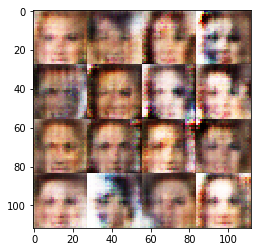

Epoch 1/1... D_Loss: 1.6810... G_Loss: 0.6654
Epoch 1/1... D_Loss: 1.6146... G_Loss: 0.6000
Epoch 1/1... D_Loss: 1.5889... G_Loss: 0.6402
Epoch 1/1... D_Loss: 1.5886... G_Loss: 0.6553
Epoch 1/1... D_Loss: 1.5357... G_Loss: 0.6730
Epoch 1/1... D_Loss: 1.4726... G_Loss: 0.6929
Epoch 1/1... D_Loss: 1.5782... G_Loss: 0.5938
Epoch 1/1... D_Loss: 1.5773... G_Loss: 0.8984
Epoch 1/1... D_Loss: 1.7746... G_Loss: 0.4720
Epoch 1/1... D_Loss: 1.6555... G_Loss: 0.6413


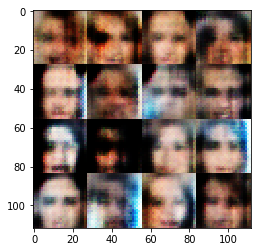

Epoch 1/1... D_Loss: 1.5222... G_Loss: 0.8014
Epoch 1/1... D_Loss: 1.4523... G_Loss: 0.5893
Epoch 1/1... D_Loss: 1.5249... G_Loss: 0.6278
Epoch 1/1... D_Loss: 1.5215... G_Loss: 0.5747
Epoch 1/1... D_Loss: 1.4470... G_Loss: 0.7777
Epoch 1/1... D_Loss: 1.5366... G_Loss: 0.8187
Epoch 1/1... D_Loss: 1.5320... G_Loss: 0.7710
Epoch 1/1... D_Loss: 1.4898... G_Loss: 0.6328
Epoch 1/1... D_Loss: 1.5888... G_Loss: 0.5684
Epoch 1/1... D_Loss: 1.5046... G_Loss: 0.7075


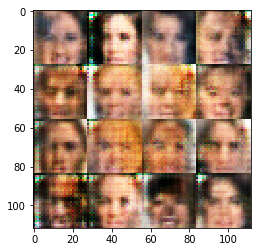

Epoch 1/1... D_Loss: 1.5347... G_Loss: 0.8089
Epoch 1/1... D_Loss: 1.4717... G_Loss: 0.8501
Epoch 1/1... D_Loss: 1.4806... G_Loss: 0.6930
Epoch 1/1... D_Loss: 1.4475... G_Loss: 0.7321
Epoch 1/1... D_Loss: 1.4806... G_Loss: 0.7484
Epoch 1/1... D_Loss: 1.5397... G_Loss: 0.5368
Epoch 1/1... D_Loss: 1.7011... G_Loss: 0.5553
Epoch 1/1... D_Loss: 1.5427... G_Loss: 0.6001
Epoch 1/1... D_Loss: 1.6309... G_Loss: 0.5990
Epoch 1/1... D_Loss: 1.4954... G_Loss: 0.5879


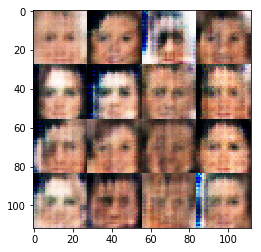

Epoch 1/1... D_Loss: 1.4999... G_Loss: 0.7565
Epoch 1/1... D_Loss: 1.5521... G_Loss: 0.5303
Epoch 1/1... D_Loss: 1.4402... G_Loss: 0.7229
Epoch 1/1... D_Loss: 1.4867... G_Loss: 0.6590
Epoch 1/1... D_Loss: 1.5231... G_Loss: 0.7433
Epoch 1/1... D_Loss: 1.6255... G_Loss: 0.6174
Epoch 1/1... D_Loss: 1.5847... G_Loss: 0.5651
Epoch 1/1... D_Loss: 1.4813... G_Loss: 0.6531
Epoch 1/1... D_Loss: 1.4526... G_Loss: 0.7289
Epoch 1/1... D_Loss: 1.6534... G_Loss: 0.5587


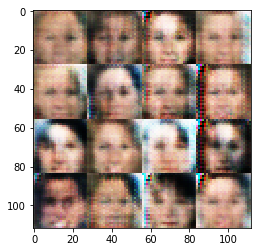

Epoch 1/1... D_Loss: 1.4654... G_Loss: 0.6476
Epoch 1/1... D_Loss: 1.4684... G_Loss: 0.6554
Epoch 1/1... D_Loss: 1.4750... G_Loss: 0.7356
Epoch 1/1... D_Loss: 1.5034... G_Loss: 0.8255
Epoch 1/1... D_Loss: 1.6416... G_Loss: 0.5977
Epoch 1/1... D_Loss: 1.5070... G_Loss: 0.6736
Epoch 1/1... D_Loss: 1.6757... G_Loss: 0.5992
Epoch 1/1... D_Loss: 1.5489... G_Loss: 0.6242
Epoch 1/1... D_Loss: 1.7139... G_Loss: 0.5977
Epoch 1/1... D_Loss: 1.6716... G_Loss: 0.5223


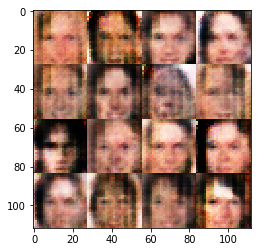

Epoch 1/1... D_Loss: 1.6025... G_Loss: 0.5480
Epoch 1/1... D_Loss: 1.5431... G_Loss: 0.7156
Epoch 1/1... D_Loss: 1.5834... G_Loss: 0.5334
Epoch 1/1... D_Loss: 1.6054... G_Loss: 0.5402
Epoch 1/1... D_Loss: 1.5225... G_Loss: 0.6172
Epoch 1/1... D_Loss: 1.5077... G_Loss: 0.6393
Epoch 1/1... D_Loss: 1.4665... G_Loss: 0.7137
Epoch 1/1... D_Loss: 1.4850... G_Loss: 0.6562
Epoch 1/1... D_Loss: 1.4722... G_Loss: 0.6103
Epoch 1/1... D_Loss: 1.4376... G_Loss: 0.7775


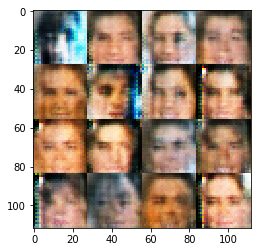

Epoch 1/1... D_Loss: 1.4597... G_Loss: 0.8187
Epoch 1/1... D_Loss: 1.4742... G_Loss: 0.7365
Epoch 1/1... D_Loss: 1.5018... G_Loss: 0.4936
Epoch 1/1... D_Loss: 1.5324... G_Loss: 0.5118
Epoch 1/1... D_Loss: 1.5618... G_Loss: 0.7111
Epoch 1/1... D_Loss: 1.4506... G_Loss: 0.6948
Epoch 1/1... D_Loss: 1.4781... G_Loss: 0.5678
Epoch 1/1... D_Loss: 1.4574... G_Loss: 0.6573


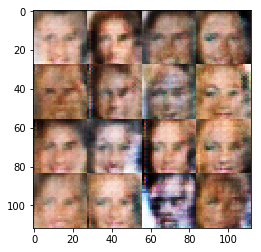

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.